<a href="https://colab.research.google.com/github/DrAlexSanz/CNN-in-TF/blob/master/CNN_in_Tensorlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains the implementation of a fully working CNN in Tensorflow. Not in pure Python.

In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image #Image tools
import tensorflow as tf #It's a tf notebook after all
# from cnn_utils import *

%matplotlib inline

np.random.seed(1)

Load the data, I have already done this dataset in some other notebook.

In [50]:
#First remove the folder and everything it contains.

!rm -rf CNN-in-TF

#Now I clone the repository and everything works.

! git clone https://github.com/DrAlexSanz/CNN-in-TF.git

Cloning into 'CNN-in-TF'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [51]:
# train_X_orig, train_Y_orig, test_X_orig, test_Y_orig = load_dataset()

with h5py.File("CNN-in-TF/test_signs.h5") as test:
  test_x_1 = np.array(test["test_set_x"][:]) # your train set features
  test_y_1 = np.array(test["test_set_y"][:]) # your train set labels
  classes = np.array(test["list_classes"][:]) # the list of classes

with h5py.File("CNN-in-TF/train_signs.h5") as train:
  train_x_1 = np.array(train["train_set_x"][:]) # train set features
  train_y_1 = np.array(train["train_set_y"][:]) # train set labels

print("Everything loaded and imported")



Everything loaded and imported


Now I am going to check that I can see the images.

y = 2


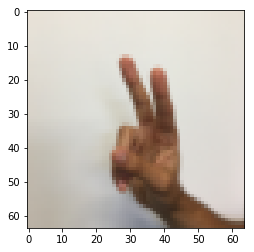

In [52]:
plt.imshow(train_x_1[645])
print("y = " + str(train_y_1[645 ]))

Now normalize and get the shapes of the dataset. Convert Y to one hot encoding. I could classify without it but I will use a softmax in the last layer, to predict [1,0,0,0,0] using a softmax function. Other than that, I could not transform it and then use an if-elif statement at the end, like my own softmax.

In [0]:
train_x = train_x_1/255
test_x = test_x_1/255

#One hot encoding by hand. I find it's a neat solution

n_classes = 5

# If I use a library, like sklearn or TF, I will fit it with the train set, and then transform BOTH, to ensure that every class is mapped consistently

#Explanation: create a nxn Identity matrix. Take the nth row. I had to write this down, it's not easy to see off the top of my head.

train_y = np.eye(n_classes+1)[train_y_1.reshape(-1)]
test_y = np.eye(n_classes+1)[test_y_1.reshape(-1)]





I need to know and check the shapes, for the placeholders and tensors later.

In [54]:
print("Number of train examples is: " + str(train_x.shape[0]))
print("Dimensions of train pictures is: " + str(train_x.shape))

print("Number of test examples is: " + str(test_x.shape[0]))
print("Dimensions of test pictures is: " + str(test_x.shape))

print("The shape of the train labels is: " + str(train_y.shape))
print("The shape of the test labels is: " + str(test_y.shape))

Number of train examples is: 1080
Dimensions of train pictures is: (1080, 64, 64, 3)
Number of test examples is: 120
Dimensions of test pictures is: (120, 64, 64, 3)
The shape of the train labels is: (1080, 6)
The shape of the test labels is: (120, 6)


Now I will make a function to create the placeholders, another to initialize the weights, another one to do the forward pass (the only one I need in tensorflow), and another to split in minibatches. Like this I can comment it out to see what happens with a full batch.

In [0]:
def create_placeholders(height, width, channels, n_classes):
    """
    the first three parameters are the dimensions of the pictures, and the last
    is the number of classes
    
    returns X and Y, two placeholders for the input and output  
    """
    
    X = tf.placeholder(tf.float32, name = "X", shape = [None, height, width, channels])
    Y = tf.placeholder(tf.float32, name = "Y", shape = [None, n_classes])
    
    # Remember, None allows me not to decide the shape now, so I can change the batch size
    
    return X,Y

In [56]:
#Check

X, Y = create_placeholders(64, 64, 3, 13)

print("X = " + str(X))
print("Y = " + str(Y))

X = Tensor("X_1:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Y_1:0", shape=(?, 13), dtype=float32)


Now I have to initialize the weights. I use Xavier initialitation. I could also use He or random. This is not so relevant, it's just a starting point for the gradient descent and in this case it's not too relevant.

In [0]:
def initialize_param():  
    """
    This function initializes W1 and W2, or more if I want.
    To play a bit with the network topology it's better to use keras or my old 
    notebook with the python NN. It's much more flexible.
    
    The CNN part is: W1 = [4, 4, 3, 8]
                      W2 = [2, 2, 8, 16]
                      
    Returns a dictionary with W1 and W2
    
    """
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters  
    
    

And now check that it all works.

In [58]:
tf.reset_default_graph() #delete everything first

with tf.Session() as sess_test:
    parameters = initialize_param()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1, 1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1, 1,1]))

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


Now forward propagation.

In [0]:
def forward_prop(X, param):
    """
    First, this function is the forward network. The topology is:
    CONV -> RELU -> MAXPOOL
    +
    CONV -> RELU -> MAXPOOL
    +
    FLATTEN -> 1 layer DENSE (with linear activation)
    
    The input is X, the train or test samples, the parameters dict {W1, W2}
    
    the output is Z3, without the softmax (TF does that in the cost)
        
    """
    
    W1 = param["W1"]
    W2 = param["W2"]
    
#     print(W1.graph)
#     print(W2.graph)
#     print(X.graph)
#     print(Y.graph)
    
    # Now first CONV2D
    # First and last strides are 1 ALWAYS, the first is for the batch (convolve 1 batch each time) and the last is for colours. Convolve one colour at a time.
    # 2 and 3 are for strides in 2D, the height and width
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1, 1, 1, 1], padding = "SAME")
    #RELU
    
    A1 = tf.nn.relu(Z1)
    
    #MAXPOOL 8x8 filter, stride 8
    
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding = "SAME")
    
    #second batch of Conv layer
    
    Z2 = tf.nn.conv2d(P1, W2, strides = [1, 1, 1, 1], padding = "SAME")
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding = "SAME")
    
    # Now I flatten the output, I need to input P2 to a fully connected layer
    
    F = tf.contrib.layers.flatten(P2)
    
    # Z3 is the best Z ever!!! XD
    
    # F is the input, 6 is the output, 5 classes and UNK. Note activation is none
    Z3 = tf.contrib.layers.fully_connected(F, 6, activation_fn = None)
    
    return Z3 
    
    
    


And as usual, now I check it.

In [60]:
tf.reset_default_graph()

with tf.Session() as sess1:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    param = initialize_param()
    Z3 = forward_prop(X, param)
    init = tf.global_variables_initializer()
    sess1.run(init)
    aaaa = sess1.run(Z3, {X: np.random.randn(2, 64, 64, 3), Y: np.random.rand(2, 6)})
    
    print("Z3 = " + str(aaaa))

Z3 = [[ 1.4416982  -0.24909668  5.4504995  -0.2618962  -0.20669872  1.3654671 ]
 [ 1.4070847  -0.02573182  5.08928    -0.4866991  -0.4094069   1.2624853 ]]


Now the cost function and this should be almost everything

In [0]:
def calc_cost(Z3, Y):
    """
    This function takes the linear output, does a softmax and compute the cost
    Y is hte labels of the samples, true ones
    
    returns the cost function    
    """
    
    cost = tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y)
    cost = tf.reduce_mean(cost)
    
    return cost

And check it.

In [62]:
tf.reset_default_graph()

with tf.Session() as sess2:
    np.random.seed(13)
    X, Y = create_placeholders(64, 64, 3, 6)
    param = initialize_param()
    Z3 = forward_prop(X, param)
    cost = calc_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess2.run(init)
    aaaa = sess2.run(cost, {X: np.random.randn(4, 64, 64, 3), Y: np.random.rand(4, 6)})
    print("cost = " + str(aaaa))
    

cost = 11.630613


I have to split the samples in mini batches before I forget.

In [0]:
def split_mini_batches(X, Y, size, seed = 0):
    """
    X, Y are the training X and Y.
    size is the size of the minibatch (13 images for example). Because size matters XD.
    seed for repeatibility
    
    returns a list of mini batches
    
    """
    
    m = X.shape[0] # Number of training samples
    mini_batches = [] # To append later
    np.random.seed(seed)
    
    # First I shuffle, they may not be shuffled beforehand.
    permutation = list(np.random.permutation(m)) # This creates a list of shuffled elements (indices)
    
    X_shuffle = X[permutation, :, :, :] #This is just a reordering
    Y_shuffle = Y[permutation, :]
    
    # Now split
    
    num_complete_minis = math.floor(m/size) # So this calculates how many mini batches I will have. It's a step size.
    
    for i in range(0, num_complete_minis):
        mini_X = X_shuffle[i*size : i*size + size, :, :, :] # Take a slice of size, starting from current_point to current_point+size
        mini_Y = Y_shuffle[i*size : i*size + size, :]
        mini_batches.append((mini_X, mini_Y))
        
    #Last batch
    
    if m % size != 0:
        mini_X = X_shuffle[num_complete_minis*size : m, :, :, :] # Take a slice of size, starting from current_point to current_point+size
        mini_Y = Y_shuffle[num_complete_minis*size : m, :]
        mini_batches.append((mini_X, mini_Y))
        
    return mini_batches
        

Now I will put all in a function to run the model easily.

In [0]:
def model(X_train, Y_train, X_test, Y_test, size, lr, epochs, print_cost):
  """"
  The function takes the train and test samples, the lr, the size of the mini batches, number of epochs and the TRUE/FALSE variable to print the cost or not
  
  Returns:
  train accuracy, test accuracy, parameters learnt by the model. With these I predict new pictures.
  
  """
  
  tf.reset_default_graph() # Like this I won't overwrite when I predict
  
  # Get the parameters for sizes and dimensions
  
  (m, height, width, c) = X_train.shape
  n_Y = Y_train.shape[1]
  costs = []
  seed = 0
  
  # Create the placeholders with the correct dimensions
  
  X, Y = create_placeholders(height, width, c, n_Y)
  
  # Initialize parameters
  
  params = initialize_param()
  
  # Do the forward prop
  
  Z3 = forward_prop(X, params)
  
  cost = calc_cost(Z3, Y)
  
  # BACKPROP!!! Luckily I only need the optimizer.
  
  optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)
  
  init = tf.global_variables_initializer()
  
  # Now start the session to start running the graph
  
  with tf.Session() as sess:
      sess.run(init)
      
      # Training loop
      
      for epoch in range(epochs):
          mini_cost = 0
          num_minis = int(m / size)
          seed = seed + 1
          minibatches = split_mini_batches(X_train, Y_train, size, seed)
          
          for minibatch in minibatches:
              (mini_X, mini_Y) = minibatch
              
              # Now I really run the optimization
              
              _, temp_cost = sess.run([optimizer, cost], feed_dict = {X: mini_X, Y: mini_Y})
              
              mini_cost = mini_cost + temp_cost / num_minis
              
      # Print the cost for epoch
      
          costs.append(mini_cost)
          if print_cost == True and epoch % 10 == 0:
              print("Cost after epoch %i: %f" % (epoch, mini_cost))
      
      # Now I plot the cost evolution
      
      
      print("The learning rate is: ", lr)
      
      # Now I really predict to calculate the accuracy
      
      predicted = tf.argmax(Z3,1)
      correct = tf.equal(predicted, tf.argmax(Y, 1))
      
      # Test accuracy
      
      accuracy = tf.reduce_mean(tf.cast(correct, "float"))
      
      train_acc = accuracy.eval({X: X_train, Y: Y_train})
      test_acc =accuracy.eval({X: X_test, Y: Y_test})
      
      print("Train accuracy is: ", train_acc)
      print("Test accuracy is: ", test_acc)
      
      
      plt.plot(costs)
      plt.ylabel("Cost")
      plt.xlabel("Epoch")
      plt.show()

      return train_acc, test_acc, params
  
  
  
  

With this I can run the model and predict. I need to define the arguments and that is it.

In [65]:
train_y.shape

(1080, 6)

Cost after epoch 0: 1.860940
Cost after epoch 10: 1.024096
Cost after epoch 20: 0.777069
Cost after epoch 30: 0.663493
Cost after epoch 40: 0.577935
Cost after epoch 50: 0.519973
Cost after epoch 60: 0.430012
Cost after epoch 70: 0.399509
Cost after epoch 80: 0.328203
Cost after epoch 90: 0.305356
Cost after epoch 100: 0.305271
Cost after epoch 110: 0.247240
Cost after epoch 120: 0.218910
Cost after epoch 130: 0.229238
Cost after epoch 140: 0.226616
The learning rate is:  0.005
Train accuracy is:  0.9425926
Test accuracy is:  0.81666666


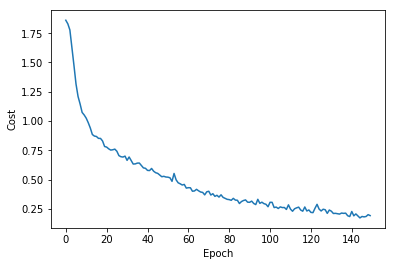

In [67]:
learn = 5e-3
epochs = 150
size = 32
print_cost = True

# Now I can just run the model

_, _, parameters = model(train_x, train_y, test_x, test_y, size, learn, epochs, print_cost)



Careful with the indent for the if!! It's very confusing to see the empty plot. I would play a bit with the hyperparameters but this is not necessary. Plus it takes long to run.

Just to summarize:



1.   Learning rate of 5e-2 may be a bit too large. 5e-3 is OK I think.
2.   Batch size of more than 64 may be a bit too large too.
3.   Batch size of 1 (SGD) is slow
4.   150 epochs should be ok. Tuning the learning rate I may be able to get a better acuracy.



